# INTRODUCTION: MODEL 1

**Model** that is used to map steady-state speed to throttle is given as follows:

$\displaystyle{ \hat{u}_s = \beta_1 \left(1 - e^{\beta_2 (v_s - \beta_3)} \right), \; \hat{u}_s \geq 0 }$

where $u_s$ is throttle, $v_s$ is steady-state speed given constant input, and $\beta_1, \beta_2, \beta_3 \in \Re$

The **optimization formulation** is given by:

$ \displaystyle{
J = \frac{1}{2m} \sum_{i=1}^m \left[u_s - \hat{u}_s \right]^2
} $

In this section, **flower pollination algorithm** (FPA) will be used to minimize the cost function $J$. The constraint is described as follows:

$ \displaystyle{
    \beta_1, \beta_3 \geq 0
} $

$\displaystyle{
\beta_2 \leq 0
}$

# IMPORT LIBRARY AND DATA

In [1]:
import numpy as np
import numba as nb
import math
import matplotlib.pyplot as plt
import pandas as pd
import time
from numba import jit, njit, types, vectorize, prange
from numba import jitclass, int32, float32, int64, float64
from multiprocessing import Pool
from os import listdir
from os.path import isfile, join

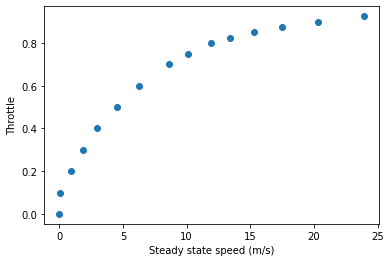

In [2]:
df = pd.read_csv('../steady_state_response.csv')
v = np.array(df.ssv)
u = np.array(df.u)

plt.scatter(v, u)
plt.xlabel('Steady state speed (m/s)')
plt.ylabel('Throttle')
plt.show()

# MAKE FUNCTION

## Generate population

In [3]:
def generate_population(num, dim, rng):
    """
    Generate flowers:
        Input:
            num: number of flowers (integer)
            dim: number of parameters (integer)
            rng: range number used in initialization (list or numpy array)
        Output:
            flws: initial position of the flowers (numpy array)
    """
    flws = np.zeros((num,dim))
    for i in range(dim):
        lim = rng[i]
        flws[:, i] = np.random.uniform(lim[0], lim[1], size=num)
    return flws

## Constraint

In [4]:
@njit
def admissible(param):
    b1, b2, b3 = param
    if b1 < 0. or b2 > 0. or b3 < 0.:
        return False
    else:
        return True
_ = admissible(np.random.randn(3))

## Forward propagation

In [5]:
@njit
def forward_propagation(u, param):
    b1, b2, b3 = param
    
    out = b1 * (1 - np.exp(b2*(u))) + b3
    out = np.fmax(out, 0.)
    
    # When the vehicle is not moving
    out[u <= 1e-2] = 0.
    
    return out

_ = forward_propagation(np.array([0.0, 0.1]), np.ones(3)*0.5)

## Cost and metric

In [6]:
@njit
def cost(u, v, param):
    error = v - forward_propagation(u, param)
    cost = np.dot(error.T, error)
    return cost
_ = cost(v, u, np.ones(3)*0.5)

In [7]:
@njit
def calculate_total_cost(param):    
    if admissible(param):
        loss = cost(v, u, param)
    else:
        loss = np.Inf
    return loss
_ = calculate_total_cost(np.ones(3)*0.5)

In [8]:
@njit(parallel=True)
def flowers_cost(flowers):
    length = flowers.shape[0]
    losses = np.zeros(length)
    for ii in prange(length):
        losses[ii] = calculate_total_cost(flowers[ii])
    return losses
_ = flowers_cost(np.random.randn(2,3))

## Pollination

In [9]:
@njit(parallel = True)
def fpa(flowers, loss_flowers, global_, global_loss_, p, alpha, gamma, var, s0):
    num = flowers.shape[0]
    dim = flowers.shape[1]    
    out = np.empty(flowers.shape)
    temp = np.empty(dim)
    loss = np.empty(loss_flowers.shape)
    temp_loss = 0.
    random_number = np.random.uniform(0., 1., num)
    for i in prange(num):
        # GLOBAL POLLINATION
        if random_number[i] < p:
            # Generate Levy Flight
            upper = np.random.normal(0., np.sqrt(var), size=dim)
            lower = np.abs(np.random.normal(0., 1., size=dim))**(1./alpha)
            L = np.divide(upper, lower)
            
            for j in range(L.shape[0]):
                if L[j] < s0:
                    L[j] = s0
            
            temp = flowers[i] + gamma * L * (global_ - flowers[i])
        # LOCAL POLLINATION
        else:
            while(True):
                i1, i2 = np.random.randint(0, num, size=2)
                if i1==i2 or i1==i or i2==i:
                    if num <= 5: # For breaking the loop
                        None
                    else:
                        continue
                break
            epsilon = np.random.uniform(0.,1.)
            
            temp = flowers[i] + epsilon * (flowers[i1] - flowers[i2])
        
        # CALCULATE COST
        temp_loss = calculate_total_cost(temp)
        if np.isnan(temp_loss):
            temp_loss = np.Inf
        
        # UPDATE
        if temp_loss < loss_flowers[i]:
            out[i] = temp
            loss[i] = temp_loss
        else:
            out[i] = flowers[i]
            loss[i] = loss_flowers[i]
    
    min_idx = np.argmin(loss)
    min_loss = loss[min_idx]
    if global_loss_ > min_loss:
        global_loss_new = min_loss
        global_new = out[min_idx, :]
    else:
        global_new = global_
        global_loss_new = global_loss_
    
    return out, loss, global_new, global_loss_new

xx1 = np.ones((2, 3))*1.0
xx2 = np.ones(2)
xx3 = np.ones(3)*0.5
_ = fpa(xx1, xx2, xx3, 100.0, 0.8, 1.5, 0.1, 0.69, 0.1)

# SIMULATION

In [10]:
num = 50

r_b1 = [0., 2.]
r_b2 = [0., -2.]
r_b3 = [0., 2.]

rng = [r_b1, r_b2, r_b3]
dim = len(rng)

s0 = 0.1
p_threshold = 0.8
alpha = 1.5
gamma = 0.1
var = (math.gamma(1+alpha)/alpha/math.gamma((1+alpha)/2) * np.sin(np.pi * alpha/2)/2**((alpha-1)/2))**(1/alpha)

In [11]:
start_time = time.clock()

flowers = generate_population(num, dim, rng)
global_ = None
global_loss_ = np.Inf

loss_flowers = flowers_cost(flowers)
loss_flowers[np.isnan(loss_flowers)] = np.Inf
min_idx = np.argmin(loss_flowers)
min_loss = loss_flowers[min_idx]
if global_loss_ > min_loss:
    global_loss_ = min_loss
    global_ = flowers[min_idx, :]

total_itr = 10000
global_history = np.empty((total_itr, dim))
global_history[0] = global_
global_loss_history = np.empty(total_itr)
global_loss_history[0] = global_loss_
for i in range(1, total_itr):
    # Flower Pollination Algorithm
    flowers, loss_flowers, global_, global_loss_ = fpa(flowers, loss_flowers, global_, global_loss_, p_threshold, alpha, gamma, var, s0)
    
    print('iteration: {} || global_loss: {:.5f}'.format(i, global_loss_))
     
    global_history[i] = global_
    global_loss_history[i] = global_loss_
    
end_time = time.clock()

/home/adamsyah/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


iteration: 1 || global_loss: 0.11009
iteration: 2 || global_loss: 0.11009
iteration: 3 || global_loss: 0.11009
iteration: 4 || global_loss: 0.11009
iteration: 5 || global_loss: 0.11009
iteration: 6 || global_loss: 0.11009
iteration: 7 || global_loss: 0.11009
iteration: 8 || global_loss: 0.11009
iteration: 9 || global_loss: 0.11009
iteration: 10 || global_loss: 0.11009
iteration: 11 || global_loss: 0.11009
iteration: 12 || global_loss: 0.11009
iteration: 13 || global_loss: 0.11009
iteration: 14 || global_loss: 0.11009
iteration: 15 || global_loss: 0.11009
iteration: 16 || global_loss: 0.09437
iteration: 17 || global_loss: 0.09437
iteration: 18 || global_loss: 0.09437
iteration: 19 || global_loss: 0.09437
iteration: 20 || global_loss: 0.09437
iteration: 21 || global_loss: 0.06895
iteration: 22 || global_loss: 0.04261
iteration: 23 || global_loss: 0.04261
iteration: 24 || global_loss: 0.04261
iteration: 25 || global_loss: 0.04261
iteration: 26 || global_loss: 0.04261
iteration: 27 || glob

/home/adamsyah/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [12]:
print('Execution Time: {}'.format(end_time - start_time))

Execution Time: 14.529759000000002


In [13]:
# Save the simulation
'''
np.save('global_history.npy', global_history)
np.save('global_loss_history.npy', global_loss_history)
'''

"\nnp.save('global_history.npy', global_history)\nnp.save('global_loss_history.npy', global_loss_history)\n"

# RESULT

In [14]:
# # Load the model
# global_history = np.load('results/global_history.npy') # Perhatikan directory nya
# global_loss_history = np.load('results/global_loss_history.npy') # Perhatikan directory nya
# global_ = global_history[-1]
# global_loss_ = global_loss_history[-1]

In [15]:
print('Minimum Cost: {}'.format(global_loss_))
print('Parameters:')
print(global_)

Minimum Cost: 0.00017618958444980178
Parameters:
[ 0.85009553 -0.14497243  0.09623465]


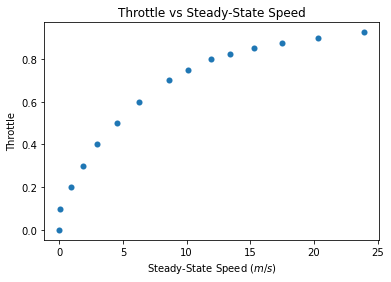

In [16]:
plt.scatter(v, u, linewidth=0.05)
plt.xlabel(r'Steady-State Speed $(m/s)$')
plt.ylabel('Throttle')
plt.title('Throttle vs Steady-State Speed')
# plt.savefig('images/throttle_vs_speed', dpi=600)
plt.show()

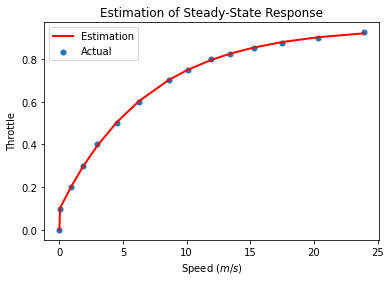

In [17]:
plt.scatter(v, u, label='Actual', linewidth=0.05)
plt.plot(v, forward_propagation(v, global_), label='Estimation', color='red', linewidth=2)
plt.xlabel(r'Speed $(m/s)$')
plt.ylabel('Throttle')
plt.title('Estimation of Steady-State Response')
plt.legend()
# plt.savefig('images/throttle_vs_speed_pred', dpi=600)
plt.show()